In [1]:
# for the model
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

# for data manipulation and graphing
from IPython.display import display, HTML

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob

import netron

tf.random.set_seed(42) # set seed for reproducibility
tf.debugging.set_log_device_placement(False)

## Data preprocessing

Taking all the csv files from the directory and joining them in one dataset

In [2]:
# Obtén una lista de todos los archivos CSV en la carpeta
csv_files = glob.glob(r'../datasets/*.csv')

datasets = [pd.read_csv(file) for file in csv_files]

dataset = pd.concat(datasets, ignore_index=True)

In [3]:
dataset.head()

,ID,Issue_Key,Type,Status,Resolution,Creation_Date,Resolution_Date,Story_Point,Timespent,In_Progress_Minutes,Total_Effort_Minutes,Resolution_Time_Minutes
0,384741,APIKIT-77,Enhancement Request,Closed,Fixed,2013-05-03 18:25:11,2014-08-14 23:32:03,8.0,NaN,0,0,674226
1,384774,APIKIT-31,Bug,Closed,Fixed,2013-07-09 00:25:17,2013-07-15 20:30:29,1.0,NaN,0,0,9845
2,384770,APIKIT-38,Bug,Closed,Fixed,2013-07-10 02:35:20,2013-08-16 19:52:51,8.0,NaN,0,0,54317
3,384769,APIKIT-39,Bug,Closed,Fixed,2013-07-10 03:10:02,2013-07-19 18:34:24,2.0,NaN,0,0,13884
4,384767,APIKIT-41,Bug,Closed,Fixed,2013-07-10 19:44:35,2013-07-15 20:27:39,1.0,NaN,54,54,7243


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54109 entries, 0 to 54108
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       54109 non-null  int64  
 1   Issue_Key                54109 non-null  object 
 2   Type                     47205 non-null  object 
 3   Status                   47205 non-null  object 
 4   Resolution               54109 non-null  object 
 5   Creation_Date            47205 non-null  object 
 6   Resolution_Date          47186 non-null  object 
 7   Story_Point              47824 non-null  float64
 8   Timespent                7540 non-null   float64
 9   In_Progress_Minutes      54109 non-null  int64  
 10  Total_Effort_Minutes     54109 non-null  int64  
 11  Resolution_Time_Minutes  54109 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 5.0+ MB


### Cleaning the data

We will select only the columns that are high relevant to this study, also we will drop all the samples with NaN values, the ones that has zero in time_effort or with a time higher that 100 hours

In [5]:
clean_dataset = dataset[[
    'Type',
    'Story_Point',
    # 'Total_Effort_Minutes',
    # 'Resolution_Time_Minutes',
    'Timespent'
]]

clean_dataset = clean_dataset[
    (clean_dataset['Type'] != 'Question') |
    (clean_dataset['Type'] != 'Epic') |
    (clean_dataset['Type'] != 'Documentation') |
    (clean_dataset['Type'] != 'Suggestion') |
    (clean_dataset['Type'] != 'Wish')
]

clean_dataset = clean_dataset[[
    'Story_Point',
    'Timespent'
]]

Clean all the NaN values

In [6]:
clean_dataset = clean_dataset.dropna()

Clean all the values with high story points

In [7]:
clean_dataset['Story_Point'] = clean_dataset['Story_Point'].round().astype(int)

min_value = clean_dataset['Timespent'].min()
max_value = clean_dataset['Timespent'].max()

print(f'Min: {min_value}, Max: {max_value}')

clean_dataset = clean_dataset[clean_dataset['Timespent'] <= 100]
clean_dataset = clean_dataset[(clean_dataset['Story_Point'] != 0) & (clean_dataset['Story_Point'] < 17)]

min_value = clean_dataset['Timespent'].min()
max_value = clean_dataset['Timespent'].max()
print(f'Min: {min_value}, Max: {max_value}')

Min: 0.0, Max: 9430.0
Min: 0.0, Max: 100.0


In [8]:
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 267 entries, 934 to 53425
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Story_Point  267 non-null    int32  
 1   Timespent    267 non-null    float64
dtypes: float64(1), int32(1)
memory usage: 5.2 KB


### Data sampling

Split the data into train, test and validate samples to fit and evaluate the model

The percentage of each one will be

- 60% training
- 20% testing
- 20% validating

In [9]:
train_dataset, temp_test_dataset = train_test_split(clean_dataset, test_size=0.20)

validation_dataset, test_dataset = train_test_split(temp_test_dataset, test_size=0.50)

print("Samples shape")
print(f"    Train: {train_dataset.shape}")
print(f"    Test: {test_dataset.shape}")
print(f"    Validation: {validation_dataset.shape}")

Samples shape
    Train: (213, 2)
    Test: (27, 2)
    Validation: (27, 2)


### Data analysis

Calculate the correlation and other statistics on the train dataset

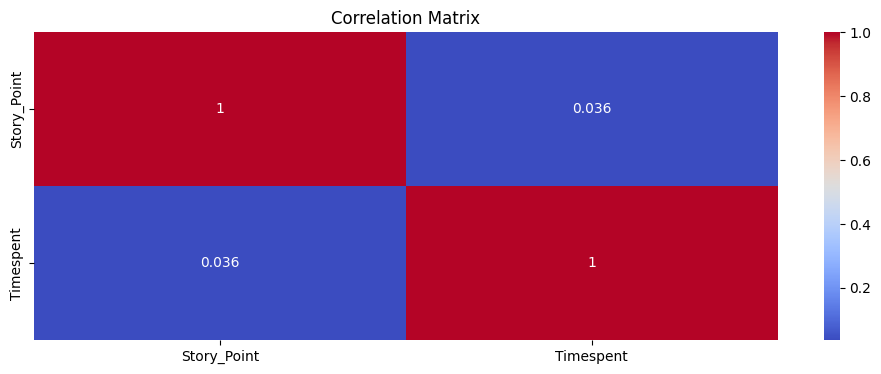

In [10]:
# correlation between the features and the target
correlation_matrix = clean_dataset.corr()
correlation_matrix['Timespent'].sort_values(ascending=False)

# plot the correlation matrix
plt.figure(figsize=(12, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [11]:
# another interesting statistics like the count, mean, std, min, quartiles and max, all per feature
train_stats = train_dataset.describe()
train_stats.pop('Timespent')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Story_Point,213.0,2.0,1.858179,1.0,1.0,1.0,2.0,12.0


### Feature prediction

The label "Hours Logged" is the actual goal for our model, we will remove it from every sample and keep it apart

In [12]:
train_label = train_dataset.pop('Timespent')
test_label = test_dataset.pop('Timespent')
validation_label = validation_dataset.pop('Timespent')

### Data normalization/Scaling

Subtract the mean of the training data and divide by the standard deviation of the training data.

In [13]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_validation_data = norm(validation_dataset)

In [14]:
normed_train_data.head()

,Story_Point
1918,0.000000
37782,-0.538161
28729,-0.538161
37793,-0.538161
45570,-0.538161


### Firts Model
Two hidden layers with 50 neurons each

In [15]:
def build_first_model_two_hidden_layers():
    model = Sequential(name = "FirstModelTwoHiddenLayers")

    # Input layer
    model.add(Input(shape=(normed_train_data.shape[1],)))

    model.add(Dense(128, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_2'))
    model.add(Dense(32, Activation('relu'), name='hidden_layer_3'))
    model.add(Dense(16, Activation('relu'), name='hidden_layer_4'))
    model.add(Dropout(0.3))

    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.0001
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy', 'mae', 'mse'])

    return model

### Second Model

Three hidden layers with 32, 64 and 128 neurons, respectively

In [16]:
def build_second_model_three_hidden_layers():
    model = Sequential(name = "SecondModelThreeHiddenLayers")

    # Input layer
    model.add(Input(shape=(normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(128, Activation('relu'), name='hidden_layer_1'))
    
    model.add(Dense(64, Activation('relu'), name='hidden_layer_3'))
    model.add(Dropout(0.3))
    model.add(Dense(32, Activation('relu'), name='hidden_layer_2'))
    model.add(Dropout(0.2))
    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.0001
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy', 'mae', 'mse'])

    return model

### Third Model

LSTM - Recurrent Neural Network

In [17]:
def build_third_model_LSTM_hidden_layers():
    model = Sequential(name = "FourthModelLSTMHiddenLayers")

    model.add(Input(shape=(normed_train_data.shape[1],)))

    model.add(Reshape((normed_train_data.shape[1], 1)))

    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(32, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(PReLU())
    model.add(Dense(1))

    learning_rate = 0.0001
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['accuracy', 'mae', 'mse'])

    return model 

### Fourth Model

Support Vector Machine

In [18]:
def build_model_svc():
    parameters = {'kernel':('linear', 'rbf')}
    svr = SVR()
    return GridSearchCV(svr, parameters)

### Choose the model

In [19]:
def choose_model(model_type, model_number):
    if (model_type == 'Neuronal Network'):
        if (model_number == 1):
            return build_first_model_two_hidden_layers()
        elif (model_number == 2):
            return build_second_model_three_hidden_layers()
        elif (model_number == 3):
            return build_third_model_LSTM_hidden_layers()
    else:
        return build_model_svc()

Save checkpoints during training

In [20]:
checkpoint_path = r".\checkpoint_logs\data.weights.h5"

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss', 
                                                 save_best_only=True, # Default false. If you don't change the file name then the output will be overritten at each step and only the last model will be saved.
                                                 save_weights_only=True, # True => model.save_weights (weights and no structure, you need JSON file for structure), False => model.save (saves weights & structure)
                                                 verbose=0,
)

tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True)

## Model training

In [21]:
def training_neural_network_model(model):
        
        # for first model - second place
        # epochs = 80
        # batch_size = 5

        # for second model - worst for now
        # epochs = 90
        # batch_size = 10

        # for fourth model - is winning
        epochs = 80
        batch_size = 5

        history = model.fit(
            normed_train_data,
            train_label,
            batch_size=batch_size,  
            epochs=epochs, 
            verbose=0,
            shuffle=True,
            steps_per_epoch = int(len(normed_train_data) / batch_size),
            validation_data=(normed_validation_data, validation_label),
            callbacks=[
                tfdocs.modeling.EpochDots(),
                tensorboard_callback,
                ckpt_callback,
            ]
        )

        return history

In [22]:
def training_support_vector_machine_model(model):
    model.fit(normed_train_data, train_label)
    
    history = pd.DataFrame({
        'Accuracy': [model.score(normed_test_data, test_label)],
        'Best params hash': [model.best_params_],
        'Best score': [model.best_score_],
        'Best estimator': [model.best_estimator_],
    })

    print(history)
    return history

To train NN model

In [23]:
%%time
model = choose_model('Neuronal Network', 2)
history = training_neural_network_model(model)


Epoch: 0, accuracy:0.0048,  loss:1995.7085,  mae:36.3059,  mse:1995.7086,  val_accuracy:0.0000,  val_loss:2473.6687,  val_mae:42.6117,  val_mse:2534.5488,  
..

c:\Users\franc\anaconda3\envs\pasantia_ia\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


..............................................................................CPU times: total: 8.2 s
Wall time: 17.6 s


To train SVM

In [173]:
%%time
model = choose_model('Support Vector Machine', 0)
history = training_support_vector_machine_model(model)

   Accuracy   Best params hash  Best score Best estimator
0  0.019065  {'kernel': 'rbf'}   -0.041311          SVR()
CPU times: total: 78.1 ms
Wall time: 167 ms


## Predicting the data

Here we will see the first 10 rows of the predicted data, comparing it with the real one

In [24]:
example_batch = normed_train_data[:5]
example_result = model.predict(example_batch)

print("Example for the first 5 samples")
print("Predicted Hours Logged")
print(example_result)
    
print("Real Hours Logged")
print(train_label[:5])

test_predictions = model.predict(normed_test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Example for the first 5 samples
Predicted Hours Logged
[[25.840837]
 [33.49703 ]
 [33.49703 ]
 [33.49703 ]
 [33.49703 ]]
Real Hours Logged
1918     43.0
37782    10.0
28729    75.0
37793     5.0
45570     4.0
Name: Timespent, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


In [25]:
test_predictions = model.predict(normed_test_data).flatten()
predictions_dataset = pd.DataFrame({
    'Logged': test_label,
    'Predicted': test_predictions
})
predictions_dataset_csv = predictions_dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


To save NN model

In [26]:
predictions_dataset_csv.to_csv(r"./outputs/neural_network/predictions_sip.csv", index=False)

To save SVM model

In [176]:
predictions_dataset_csv.to_csv(r"./outputs/svr/predictions_sip.csv", index=False)

Predictions VS. True Values for Hours Logged

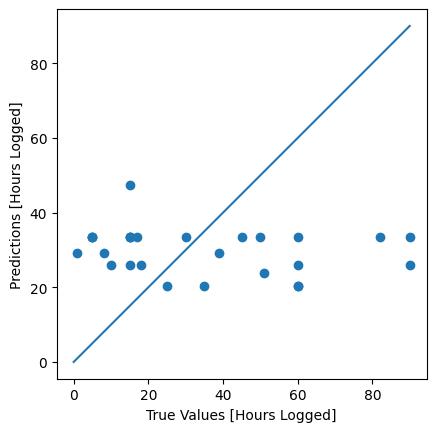

In [27]:
axes = plt.axes(aspect='equal')
plt.scatter(test_label, test_predictions)
plt.xlabel('True Values [Hours Logged]')
plt.ylabel('Predictions [Hours Logged]')
# calculate the limit
max_value = max(test_label.max(), test_predictions[0].max())
_ = plt.plot([0, max_value], [0, max_value])


To save plot for NN model

In [28]:
plt.savefig(r"./outputs/neural_network/prediction_plot_sip.png")

<Figure size 640x480 with 0 Axes>

To save plot for SVR model

In [179]:
plt.savefig(r"./outputs/svr/prediction_plot_sip.png")

<Figure size 640x480 with 0 Axes>

## Evaluating the model

The metrics we choose to evaluate the model were **Mean Abs. Error** and **Mean squarred Error**

### Showing the resulting metrics from the training

In [29]:
def evaluating_neural_network_model(history):

    history_dataset = pd.DataFrame(history.history)
    history_dataset['epoch'] = history.epoch


    print("Resume of the training history model")
    display(HTML(history_dataset.tail(5).to_html()))

    history_dataset_csv = history_dataset
    history_dataset_csv.to_csv(r"./outputs/neural_network/history_sip.csv", index=False)  

    print("Plotting the training history model per epoch")

    plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
    plotter.plot({'Basic': history}, metric="mse")
    plt.ylabel('MSE [Metric]')

    plt.savefig(r"./outputs/neural_network/training_plot_sip.png")
    plt.show()


In [30]:
def evaluating_svr_model(history, test_predictions):
    history['MAE'] = [mean_absolute_error(test_label, test_predictions)]
    history['MSE'] = [mean_squared_error(test_label, test_predictions)]

    display(HTML(history.to_html()))

    history.to_csv(r"./outputs/svr/history_sip.csv", index=False)   

    # saving the results
    pd.DataFrame({
        'Logged': test_label,
        'Predicted': test_predictions
    }).to_csv(r"./outputs/svr/history_sip.csv", index=False)

To evaluate NN model

Resume of the training history model


,accuracy,loss,mae,mse,val_accuracy,val_loss,val_mae,val_mse,epoch
75,0.000000,297.076172,18.409317,594.152344,0.037037,1008.662598,26.730024,1012.656738,75
76,0.028571,810.882629,24.319319,810.882507,0.037037,989.992188,26.537285,994.062744,76
77,0.000000,107.417519,11.878586,214.835037,0.037037,989.751465,26.535208,993.790527,77
78,0.028571,786.085449,24.047064,786.085510,0.037037,971.040283,26.334743,975.136353,78
79,0.000000,66.992821,7.226422,133.985641,0.037037,970.316345,26.328268,974.291504,79


Plotting the training history model per epoch


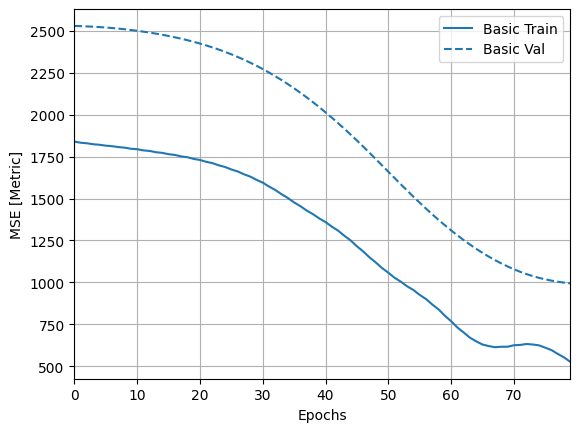

In [31]:
evaluating_neural_network_model(history)

To evaluate SVR model

In [181]:
evaluating_svr_model(history, test_predictions)

,Accuracy,Best params hash,Best score,Best estimator,MAE,MSE
0,0.019065,{'kernel': 'rbf'},-0.041311,SVR(),21.396961,653.617679


Only if the model is a NN

In [32]:
model.save(r"./outputs/neural_network/model_sip.h5")
netron.start(r"./outputs/neural_network/model_sip.h5")

Serving './outputs/neural_network/model_sip.h5' at http://localhost:8080


('localhost', 8080)